# Sentiment Analysis of financial Tweets

## Introduction
Our goal is to analyze the sentiment of tweets and use the sentiment to determine if the tweet could have an influence on the stock price.

## Data
The provided training data in training_set.csv consists of random Tweets as well as their direct influence on the stock price in the simulated stock exchange.

In [12]:
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline
import warnings
from io import StringIO
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import torch.optim as optim

warnings.filterwarnings('ignore')

data = pd.read_csv('./data/training_set.csv')
data

,SocialMediaFeed,NVDA,ING,SAN,PFE,CSCO
0,@PharmaNews: Pfizer faces backlash over possib...,0.000000,0.0,0.0,-0.029512,0.000000
1,@BusinessReport: A recent study found that mos...,0.000000,0.0,0.0,0.000000,0.000000
2,@HardwareHubs: NVIDIA's contributions to a maj...,0.026125,0.0,0.0,0.000000,0.000000
3,@HealthWatch: Johnson & Johnson faces lawsuits...,0.000000,0.0,0.0,0.000000,0.000000
4,@IndustryInsider: Magnificent Honary faces pro...,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...
993,@EquityEyes: The market was steady today. No m...,0.000000,0.0,0.0,0.000000,0.000000
994,"@Economist: Despite all the talk, a recession ...",0.000000,0.0,0.0,0.000000,0.000000
995,@HardwareHubs: Cisco faces slight increase in ...,0.000000,0.0,0.0,0.000000,-0.025912
996,@BankingBulletin: Unverified reports of ING pl...,0.000000,0.0,0.0,0.000000,0.000000


## Dataloader
To train and test our models we have to transform the data to only contain the tweet and the overall sentiment of the tweet which is determined by the influence on the share price. E.g. the first row of the table above should be negative, the second row neutral, and so on.

We set up the training data that a sentiment score of negative = 0, neutral = 1, positive = 2 

In [13]:
def calculate_overall_sentiment(row):
    """ Calculate the overall sentiment based on individual sentiment values. """
    # Flatten the row if it's a list of lists
    flattened_row = [item for sublist in row if isinstance(sublist, list) for item in sublist] if any(isinstance(x, list) for x in row) else row
    
    if any(x < 0 for x in flattened_row):
        return 0
    elif any(x > 0 for x in flattened_row):
        return 1
    else:
        return 2


sentiment_vectors = data.iloc[:, 1:-1] 
tweets = data['SocialMediaFeed']

# Calculate the overall sentiment
overall_sentiments = sentiment_vectors.apply(calculate_overall_sentiment, axis=1)

# Creating the final DataFrame with Tweet and OverallSentiment
corrected_transformed_data = pd.DataFrame({'Tweet': tweets, 'OverallSentiment': overall_sentiments}, columns=['Tweet', 'OverallSentiment'])
corrected_transformed_data.to_csv('./data/transformed_data.csv', index=False)
corrected_transformed_data

,Tweet,OverallSentiment
0,@PharmaNews: Pfizer faces backlash over possib...,0
1,@BusinessReport: A recent study found that mos...,2
2,@HardwareHubs: NVIDIA's contributions to a maj...,1
3,@HealthWatch: Johnson & Johnson faces lawsuits...,2
4,@IndustryInsider: Magnificent Honary faces pro...,2
...,...,...
993,@EquityEyes: The market was steady today. No m...,2
994,"@Economist: Despite all the talk, a recession ...",2
995,@HardwareHubs: Cisco faces slight increase in ...,2
996,@BankingBulletin: Unverified reports of ING pl...,2


In [3]:
def get_dataloader(tokenizer):
    # Tokenize and prepare dataset
    train_inputs = tokenizer(corrected_transformed_data['Tweet'].tolist(), padding=True, truncation=True, return_tensors="pt")
    test_inputs = tokenizer(pd.read_csv('./data/test_tweets.csv')['Tweet'].tolist(), padding=True, truncation=True, return_tensors="pt")
    train_input_ids = train_inputs['input_ids']
    test_inputs_ids = test_inputs['input_ids']
    train_attention_mask = train_inputs['attention_mask']
    test_attention_mask = test_inputs['attention_mask']

    train_labels = torch.tensor(corrected_transformed_data['OverallSentiment'].tolist())
    test_labels = torch.tensor(pd.read_csv('./data/test_tweets.csv')['OverallSentiment'].tolist())
    dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)

    # Split into train and validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


    test_set = TensorDataset(test_inputs_ids, test_attention_mask, test_labels)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_set, batch_size=32)
    return train_loader, val_loader, test_loader

## First Approach: Finbert

FinBERT is a variant of the BERT (Bidirectional Encoder Representations from Transformers) model that has been specifically fine-tuned for financial sentiment analysis. Originally developed by Google, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. This architecture allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

FinBERT leverages the same architecture but is fine-tuned on financial texts, such as market news, reports, or articles, making it particularly adept at understanding the nuances and jargon of financial discourse. This specialization enables FinBERT to perform tasks like sentiment analysis, financial forecasting, and risk assessment with higher accuracy compared to the general-purpose BERT model when dealing with financial texts.

The model can classify texts into categories such as positive, negative, or neutral sentiments.

In [4]:
# Load FinBERT model
model_name = "yiyanghkust/finbert-tone"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_name)

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

results = []
for i in range(len(data['SocialMediaFeed'])):
    tweet = data['SocialMediaFeed'][i]
    inputs = tokenizer(tweet, padding=True, truncation=True, return_tensors="pt")
    logits = nlp(tweet)
    result = [tweet, logits[0]['label'], logits[0]['score']]
    results.append(result)

headers = ["Tweet", "Sentiment", "Score"]
df_results = pd.DataFrame(results, columns=headers)
df_results.to_csv('finbert.csv', index=False)
df_results.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,Tweet,Sentiment,Score
0,@PharmaNews: Pfizer faces backlash over possib...,Neutral,0.998067
1,@BusinessReport: A recent study found that mos...,Neutral,0.999951
2,@HardwareHubs: NVIDIA's contributions to a maj...,Positive,1.000000
3,@HealthWatch: Johnson & Johnson faces lawsuits...,Negative,0.995370
4,@IndustryInsider: Magnificent Honary faces pro...,Negative,0.763037


# Evaluation FinBERT

The pretrained FinBERT model achieved on our test dataset an accuracy of 27% and an F1-Score of 27% which is pretty bad.
Therefore, we opted to finetune a pretrained BERT model on our dataset to achieve a better performance

In [5]:
from sklearn.metrics import accuracy_score, f1_score

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0]
            labels = batch[2]
            outputs = model(inputs, attention_mask=batch[1], labels=labels)
            
            # Convert logits to probabilities
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            
            # Get the predicted class (highest probability)
            predictions = torch.argmax(probabilities, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions, average='weighted') 
    return accuracy, f1

train_loader, val_loader, test_loader = get_dataloader(tokenizer)
accuracy, f1 = test_model(model, test_loader)
print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')

Accuracy: 0.27, F1 Score: 0.27


## Second Approach: Finetune DistilBERT

DistilBERT is a smaller, faster, lighter, and cheaper version of BERT, designed to provide a more efficient alternative for natural language processing (NLP) tasks without significantly compromising performance. It achieves this by distilling the knowledge from BERT into a smaller model with fewer parameters. DistilBERT retains about 97% of BERT's language understanding capabilities while being 40% smaller and 60% faster, making it more accessible for use in applications with limited computational resources.

For sentiment analysis, DistilBERT can be fine-tuned just like BERT to understand the nuances of language in specific contexts, including evaluating the sentiment expressed in texts. This process involves training the model on a dataset of texts labeled with sentiments (e.g., positive, negative, neutral) so that it learns to classify new, unseen texts accordingly. The efficiency of DistilBERT makes it particularly appealing for our task as we aim to get a sentiment of a tweet as fast as possible to leverage the knowledge quicker than our competitors on the stock market.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Training Loss: 0.9236598992347718
Epoch 1 - Validation Loss: 0.8386981572423663
Epoch 2 - Training Loss: 0.8146536064147949
Epoch 2 - Validation Loss: 0.7328133072171893
Epoch 3 - Training Loss: 0.6213390028476715
Epoch 3 - Validation Loss: 0.5054671083177839
Epoch 4 - Training Loss: 0.40968980312347414
Epoch 4 - Validation Loss: 0.42312466885362354
Epoch 5 - Training Loss: 0.2909572350978851
Epoch 5 - Validation Loss: 0.4062458202242851
Epoch 6 - Training Loss: 0.22503191620111465
Epoch 6 - Validation Loss: 0.3842378727027348


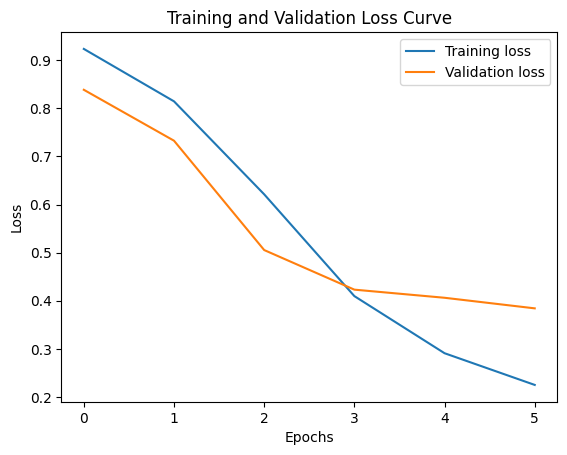

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

train_loader, val_loader, test_loader = get_dataloader(tokenizer)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.03)

# Training and validation loop
epochs = 6  # Define the number of epochs
train_losses = []
val_losses = []


for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch[0], attention_mask=batch[1], labels=batch[2])
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss}")

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(batch[0], attention_mask=batch[1], labels=batch[2])
            loss = outputs.loss
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss}")

# Plotting the loss curve
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation: Finetuned DistilBERT
The fine-tuned DistilBERT model has demonstrated commendable performance on the financial text classification task, achieving an accuracy of 81.44% and an F1 score of 81.67%. These metrics are indicative of the model's robust ability to understand and categorize financial texts accurately. The close alignment between the accuracy and F1 score suggests a balanced performance across different classes, signifying that the model is not only accurate on average but also maintains a strong precision-recall balance. This is particularly important in financial applications, where the cost of misclassification can be high. The results underscore the effectiveness of DistilBERT as a powerful, yet computationally efficient, model for natural language processing tasks within the financial domain. The fine-tuning process has evidently tailored the model's pre-existing linguistic knowledge to the specific nuances and terminology of financial texts, enabling it to provide insights and analysis that can be critical for decision-making in finance-related contexts.

In [15]:
accuracy, f1_score = test_model(model, test_loader)
print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1_score:.4f}')

Accuracy: 0.8144, F1 Score: 0.8167


## Save Model

In [16]:
# Saving the model
torch.save(model.state_dict(), './models/fine_tuned_distilbert_model.pth')

# Loading the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model = torch.load('./models/fine_tuned_distilbert_model.pth')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prediction

In [ ]:
def predict(text, model, tokenizer):
    """
    Predict the sentiment of the provided text using the given model and tokenizer.
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to logits
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get the highest probability class
    prediction = torch.argmax(probabilities, dim=-1).item()

    return prediction